Neste relatório visamos treinar um algoritmo de regressão com base em 50.000 dados com 77 dimensões usando a métrica MAE, erro absoluto médio. Primeiramente diminuiremos as dimensões dos dados com PCA, após, treinaremos diversos regressores para, enfim, realizar um ensemble e reportar as saídas esperadas.

In [1]:
# Includes
from   sklearn.gaussian_process  import GaussianProcessRegressor
from   sklearn.model_selection  import GridSearchCV, train_test_split, KFold
from   sklearn.neural_network  import MLPRegressor
from   sklearn.decomposition  import PCA
from   sklearn.preprocessing import scale
from   sklearn.linear_model import LinearRegression
from   sklearn.neighbors   import KNeighborsRegressor
from   sklearn.ensemble   import RandomForestRegressor, GradientBoostingRegressor
from   sklearn.metrics   import mean_absolute_error
from   sklearn.utils    import resample, shuffle
from   sklearn.svm     import LinearSVR
from   pickle         import Pickler
import pandas as pd
import numpy  as np
import warnings
import math
import gc

class Stacker(object):
    """
    A transformer applying fitting a predictor `pred` to data in a way
        that will allow a higher-up predictor to build a model utilizing both this 
        and other predictors correctly.

    The fit_transform(self, x, y) of this class will create a column matrix, whose 
        each row contains the prediction of `pred` fitted on other rows than this one. 
        This allows a higher-level predictor to correctly fit a model on this, and 
        other column matrices obtained from other lower-level predictors.

    The fit(self, x, y) and transform(self, x_) methods, will fit `pred` on all 
        of `x`, and transform the output of `x_` (which is either `x` or not) using 
        the fitted `pred`.

    Arguments:    
        pred: A lower-level predictor to stack.

        cv_fn: Function taking `x`, and returning a cross-validation object. In 
            `fit_transform` th train and test indices of the object will be iterated 
            over. For each iteration, `pred` will be fitted to the `x` and `y` with 
            rows corresponding to the train indices, and the test indices of the 
            output will be obtained by predicting on the corresponding indices of `x`.
    """
    def __init__(self, pred):
        self._pred  = pred

    def fit_transform(self, x, y):
        x_trans = self._train_transform(x, y)

        self.fit(x, y)

        return x_trans

    def fit(self, x, y):
        """
        Same signature as any sklearn transformer.
        """
        self._pred.fit(x, y)

        return self

    def transform(self, x):
        """
        Same signature as any sklearn transformer.
        """
        return self._test_transform(x)

    def _train_transform(self, x, y):
        x_trans = np.nan * np.ones((x.shape[0], 1))

        all_te = set()
        for tr, te in KFold().split(x):
            all_te = all_te | set(te)
            x_trans[te, 0] = self._pred.fit(x[tr, :], y[tr]).predict(x[te, :]) 
        if all_te != set(range(x.shape[0])):
            warnings.warn('Not all indices covered by Stacker', 
                                           sklearn.exceptions.FitFailedWarning)

        return x_trans

    def _test_transform(self, x):
        return self._pred.predict(x)

warnings.filterwarnings("ignore")

In [2]:
# Lê os dados do arquivo
def readIt():
    from IPython.display import display
    df = pd.io.parsers.read_csv('ex6-train.csv')
    y = df.pop('V78').as_matrix()
    x = scale(df.as_matrix());
    display(df.head())
    return x, y

x, y = readIt()
data_size = len(x)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77
0,-0.325031,-0.311748,-0.31805,-0.315876,-0.317389,-0.327516,-0.324894,-0.360825,-0.340404,-0.343175,...,-0.071290,-0.095431,-0.090428,-0.325432,-0.312178,-0.318445,-0.316260,-0.317772,-0.327894,-0.325299
1,-0.320399,-0.314061,-0.31805,-0.315876,-0.318975,-0.329010,-0.320431,-0.350666,-0.340404,-0.343175,...,-0.782664,-0.793595,-0.090428,-0.320809,-0.314487,-0.318445,-0.316260,-0.319357,-0.329387,-0.320842
2,-0.322715,-0.316374,-0.31805,-0.315876,-0.318975,-0.323033,-0.324894,-0.355746,-0.345350,-0.343175,...,-0.782664,-0.095431,-0.090428,-0.323120,-0.316796,-0.318445,-0.316260,-0.319357,-0.323417,-0.325299
3,-0.322715,-0.316374,-0.31805,-0.314137,-0.318975,-0.329010,-0.324894,-0.355746,-0.345350,-0.343175,...,-0.782664,-0.793595,-0.090428,-0.323120,-0.316796,-0.318445,-0.314523,-0.319357,-0.329387,-0.325299
4,-0.325031,-0.314061,-0.31805,-0.315876,-0.317389,-0.326021,-0.321919,-0.360825,-0.340404,-0.343175,...,-0.071290,-0.095431,-0.090428,-0.325432,-0.314487,-0.318445,-0.316260,-0.317772,-0.326402,-0.322327


# Preprocessamento
## PCA

In [3]:
def pcaIt(x):
    pca = PCA(n_components=0.85)
    pca.fit(x)
    print("Após o PCA temos", pca.n_components_,"componentes")
    return pca, pca.transform(x)
    
pca, x_reduced = pcaIt(x)

Após o PCA temos 11 componentes


# Análise visual

Componentes do dado normalizado


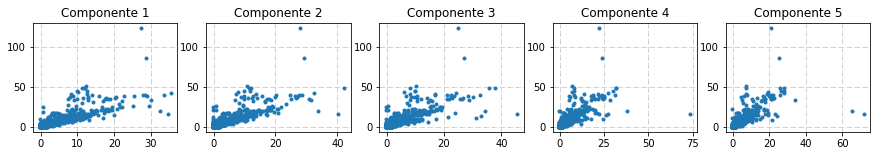

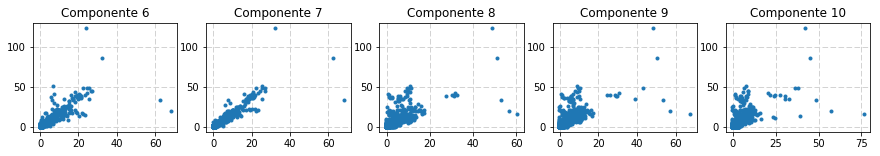

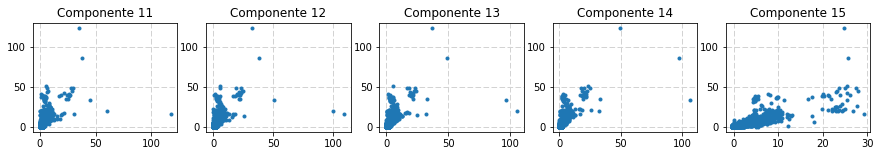

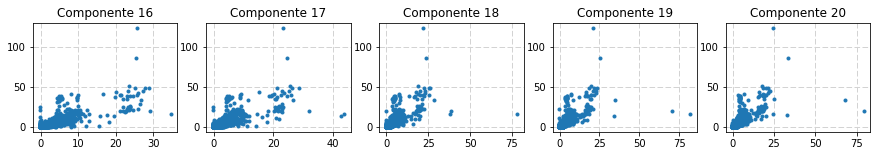

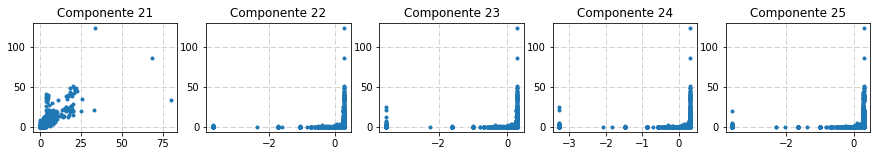

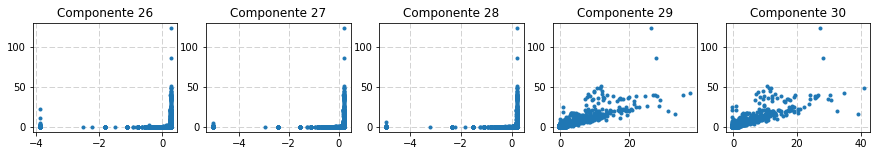

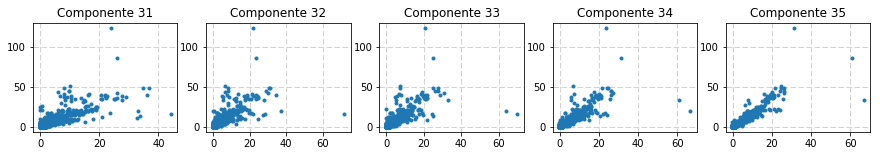

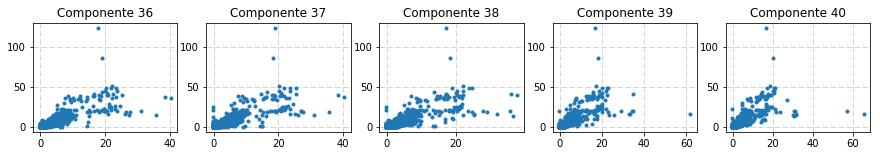

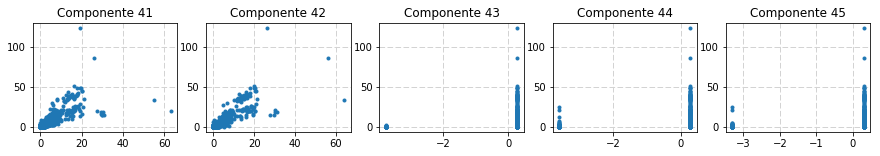

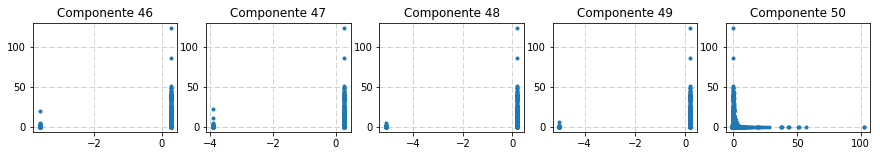

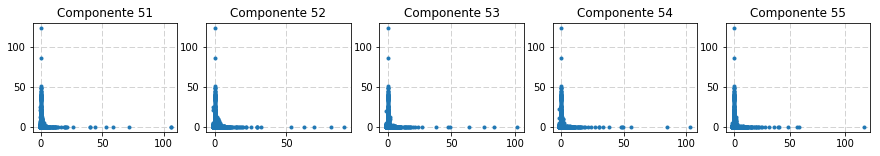

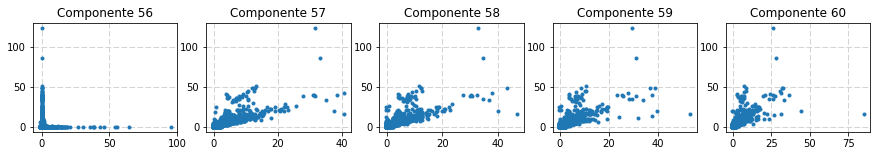

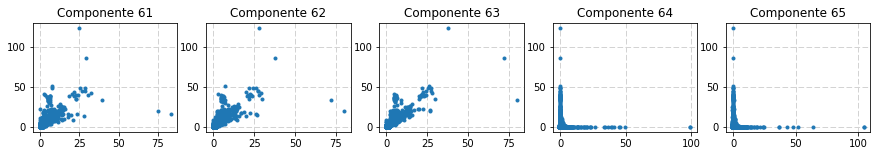

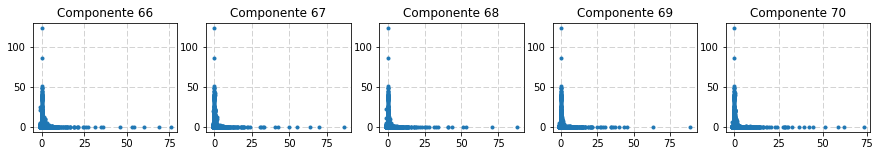

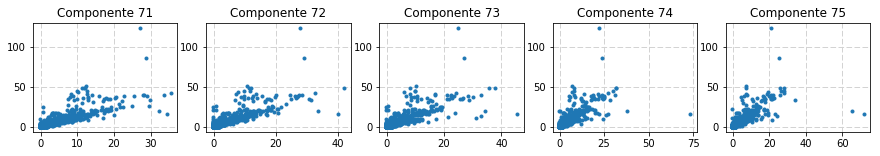

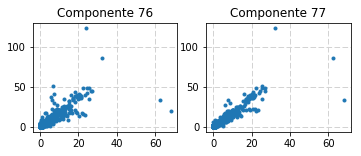

Componentes do dado após o PCA


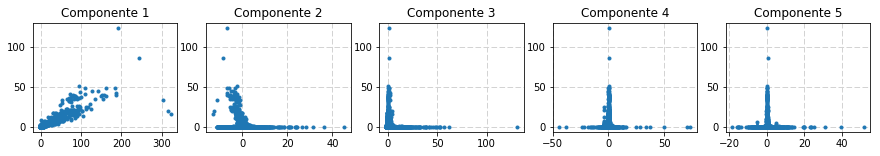

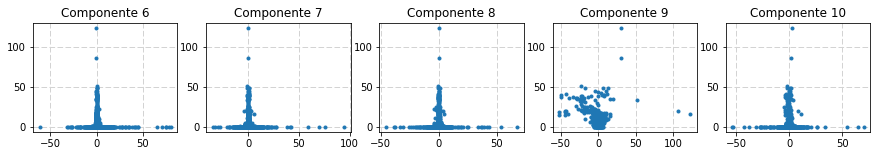

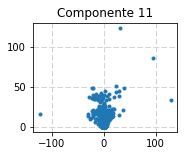

In [4]:
def plotIt():
    import matplotlib.pyplot as plt
    
    def plot(i, x, y, ncols, fig):
        if i % ncols == 0:
            fig = plt.figure(figsize=(15,2))
        ax = fig.add_subplot(1, ncols, 1+(i%ncols))
        ax.grid(color='lightgray', linestyle='--', linewidth=1)
        x_, y_ = [[*x] for x in zip(*sorted(zip(x,y)))]
        ax.plot(x_, y_, '.')
        ax.set_title("Componente {}".format(i+1))
        if i % ncols == ncols-1:
            plt.show()
        return fig

    transposed = np.transpose(x)
    transposed_reduced = np.transpose(x_reduced)
    
    fig = None
    ncols = 5
    print("Componentes do dado normalizado")
    for i in range(len(transposed)):
        fig = plot(i, transposed[i], y, ncols, fig)
    plt.show()

    print("Componentes do dado após o PCA")
    for i in range(len(transposed_reduced[:])):
        fig = plot(i, transposed_reduced[i], y, ncols, fig)
    plt.show()
    
plotIt()

Analisar as componentes isoladamente pode gerar más interpretações, mas podemos ver que algumas têm comportamentos bem similares, outras, bem comportadas, e ainda há alguns casos, como nas componentes entre 43 e 49, onde os dados variam entre 2 valores.

# Treinamento

In [6]:
def getSample(x, y, perc=0.8):
    return shuffle(x, y, n_samples=int(len(x)*perc), random_state=0)

def findHP(regressor, name, params, resultStr, x, y, n_jobs=4):
    gscv = GridSearchCV(regressor, params, n_jobs=n_jobs, 
                                    scoring='neg_mean_absolute_error', cv=3)
    gscv.fit(x,y)
    regressor = gscv.best_estimator_
    paramList = [gscv.best_params_[name] for name in sorted(params.keys())]
    formatParams = [name, -gscv.best_score_] + paramList
    resultStr = "{} >> Menor MAE em um Fold: {:.3f}; " + resultStr
    print(resultStr.format(*formatParams))
    gc.collect()

x = x_reduced

# Tamanhos arbitrariamente escolhidos conforme capacidade da máquina
sample_size = int(data_size)
train_size = int(sample_size*0.8)
test_size = sample_size - train_size

# Separa treino e teste para checar acurácia da uniÃ£o dos 6 métodos
i_tr, i_ts = train_test_split(list(range(data_size)), 
                              train_size=train_size, 
                              test_size=test_size)
x_tr, x_ts, y_tr, y_ts = x[i_tr], x[i_ts], y[i_tr], y[i_ts]

gc.collect()

109

## SVM

In [8]:
def trainSVM(x, y):
    regressor = LinearSVR(loss='epsilon_insensitive', random_state=0)
    params = {'epsilon':[0, 0.1, 1, 10], 'C':[2**-10, 2**-5, 2**1, 2**5]}
    resultStr = "C: {:.3f}; Eps: {}"
    findHP(regressor, "SVM", params, resultStr, x, y)

trainSVM(*getSample(x_tr, y_tr))

SVM >> Menor MAE em um Fold: 0.110; C: 0.031; Eps: 0


## GBM

In [9]:
def trainGBM(x, y):
    regressor = GradientBoostingRegressor(loss='lad', random_state=0)
    params ={'learning_rate':[0.1, 0.05],'max_depth':[3, 7],'n_estimators':[50, 100]}
    resultStr = "L.R.: {}; Max Depth: {}; N Est.: {}"
    findHP(regressor, "GBM", params, resultStr, x, y)

trainGBM(*getSample(x_tr, y_tr, 0.2))

GBM >> Menor MAE em um Fold: 0.107; L.R.: 0.1; Max Depth: 7; N Est.: 100


## RF

In [10]:
def trainRF(x, y):
    regressor = RandomForestRegressor(criterion='mae', random_state=0, n_jobs=4)
    params = {'n_estimators': [25, 75], 'max_depth': [3, 5]}
    resultStr = "Max Depth: {}; n_estimators: {}"
    findHP(regressor, "RF", params, resultStr, x, y, n_jobs=1)

trainRF(*getSample(x_tr, y_tr, 0.2))

RF >> Menor MAE em um Fold: 0.103; Max Depth: 5; n_estimators: 75


## RN

In [11]:
def trainRN(x, y):
    regressor = MLPRegressor(random_state=0)
    params = {'alpha':[1e-5, 1, 1e+5], 
              'hidden_layer_sizes':[(30), (70,)]}
    resultStr = "alpha: {}; Tam.Camadas: {}"
    findHP(regressor, "RN", params, resultStr, x, y)

trainRN(*getSample(x_tr, y_tr, 0.2))

RN >> Menor MAE em um Fold: 0.121; alpha: 1; Tam.Camadas: (70,)


## KNN

In [12]:
def trainKNN(x, y):
    regressor = KNeighborsRegressor(p=1)
    params ={'n_neighbors':[1, 5, 11, 15, 21, 25],'weights':['distance','uniform']}
    resultStr = "n_neighbors: {}; weights: {}"
    findHP(regressor, "KNN", params, resultStr, x, y)

trainKNN(*getSample(x_tr, y_tr))

KNN >> Menor MAE em um Fold: 0.107; n_neighbors: 15; weights: distance


## Gaussian

In [13]:
def trainGaussian(x, y, n_jobs=4): 
    regressor = GaussianProcessRegressor(copy_X_train=False, random_state=0)
    params = { 'alpha':[1e-7, 1, 1e+7]}
    resultStr = "alpha: {}"
    findHP(regressor, "Gaussian", params, resultStr, x, y, n_jobs=n_jobs)

trainGaussian(*getSample(x_tr, y_tr, 0.2))

Gaussian >> Menor MAE em um Fold: 0.190; alpha: 1


# Ensemble

In [7]:
# Gera a predição para um regressor
def trainAndPredict(regName, i_tr, i_ts, x_tr, y_tr, x_ts, y_ts=None, 
                                                        pred=np.zeros(data_size)):
    if (regName == 'SVM'):
        regressor = LinearSVR(loss='epsilon_insensitive', C=2**-5,epsilon=0, 
                                                                  random_state=0)
    elif (regName == 'GBM'):
        regressor = GradientBoostingRegressor(loss='lad', learning_rate=0.1, 
                                   max_depth=7, n_estimators=100, random_state=0)
    elif (regName == 'RF'):
        subsamplesize = int(len(i_tr)*.2)
        i_tr = i_tr[:subsamplesize]
        x_tr = x_tr[:subsamplesize]
        y_tr = y_tr[:subsamplesize]
        regressor = RandomForestRegressor(criterion='mae', max_depth=5, 
                                       n_estimators=75, random_state=0, n_jobs=4)
    elif (regName == 'RN'):
        regressor = MLPRegressor(alpha=1, hidden_layer_sizes=(70,),random_state=0)
    elif (regName == 'KNN'):
        regressor = KNeighborsRegressor(p=1, n_neighbors=15, weights='distance')
    elif (regName == 'Gaussian'):
        regressor = GaussianProcessRegressor(copy_X_train=False, alpha=1, 
                                                                   random_state=0)
        
    stacker = Stacker(regressor)
    
    
    with open(regName + '.pkl', 'wb') as output:
        pred[i_tr] = stacker.fit_transform(x_tr, y_tr)[:,0]
        
        # Guarda o regressor no disco
        Pickler(output, -1).dump(stacker)
        
        pred[i_ts] = stacker.transform(x_ts)
        if (y_ts != None):
            loss = mean_absolute_error(y_ts, pred[i_ts])
            print('{} >> MAE: {:.3f}'.format(regName, loss))
    gc.collect()
    return pred

# Inicializa o vetor de predições para y
n_regressors = 6
y_pred = np.zeros((data_size,n_regressors))
indexesAndValues = [i_tr, i_ts, x_tr, y_tr, x_ts, y_ts]

In [6]:
y_pred[:,0] = trainAndPredict('SVM', *indexesAndValues)

SVM >> MAE: 0.118


In [7]:
y_pred[:,1] = trainAndPredict('GBM', *indexesAndValues)

GBM >> MAE: 0.102


In [8]:
y_pred[:,2] = trainAndPredict('RF', *indexesAndValues)

RF >> MAE: 0.120


In [13]:
y_pred[:,3] = trainAndPredict('RN', *indexesAndValues)

RN >> MAE: 0.133


In [8]:
y_pred[:,4] = trainAndPredict('KNN', *indexesAndValues)

KNN >> MAE: 0.096


In [ ]:
# Estouro de memória
#y_pred[:,5] = trainAndPredict('Gaussian', *indexesAndValues)

In [10]:
# Gera um regressor para prever qual a melhor previsão
u = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=500, random_state=0)
        .fit(y_pred[i_tr, :], y_tr)
w = LinearRegression().fit(y_pred[i_tr, :], y_tr)

# Calcula a pontuação deste regressor 
mlpLoss = mean_absolute_error(y_ts, u.predict(y_pred[i_ts, :]))
linearLoss = mean_absolute_error(y_ts, w.predict(y_pred[i_ts, :]))
print("MLP: {:.3f}".format(mlpLoss))
print("Linear: {:.3f}".format(linearLoss))

MLP: 0.099
Linear: 0.111


In [ ]:
# Le e preprocessa os dados
df = pd.io.parsers.read_csv('ex6-test.csv')
x_res = pca.transform(scale(df.as_matrix()))

data_size_res = data_size+len(x_res)
y_pred = np.zeros((data_size_res, n_regressors))
idxs_tr = list(range(data_size))
idxs_ts = list(range(data_size, data_size+len(x_res)))
indexesAndValues = [idxs_tr, idxs_ts, x, y, x_res, None, np.zeros(data_size_res)]

y_pred[:,0] = trainAndPredict('SVM', *indexesAndValues)
y_pred[:,1] = trainAndPredict('GBM', *indexesAndValues)
y_pred[:,2] = trainAndPredict('RF', *indexesAndValues)
y_pred[:,3] = trainAndPredict('RN', *indexesAndValues)
y_pred[:,4] = trainAndPredict('KNN', *indexesAndValues)
#y_pred[:,5] = trainAndPredict('Gaussian', *indexesAndValues)

In [11]:
reg = u if mlpLoss < linearLoss else w

reg.fit(y_pred[idxs_tr], y)
predFinal = reg.predict(y_pred[idxs_ts])

pd.DataFrame(predFinal).to_csv('ex6-result.csv', header=False, index=False)

Treino: Componentes do dado normalizado após o PCA


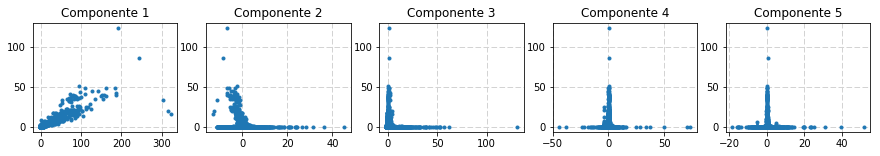

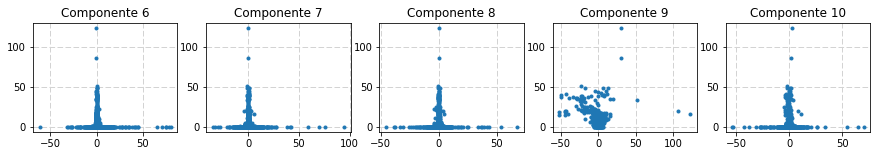

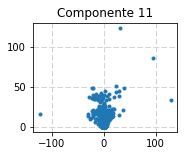

Resultado: Componentes do dado normalizado após o PCA


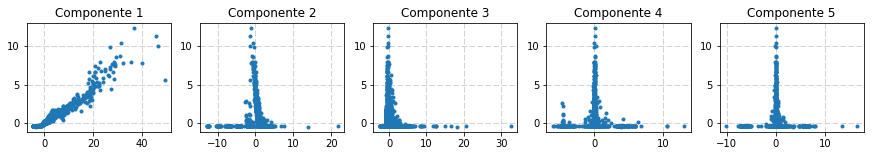

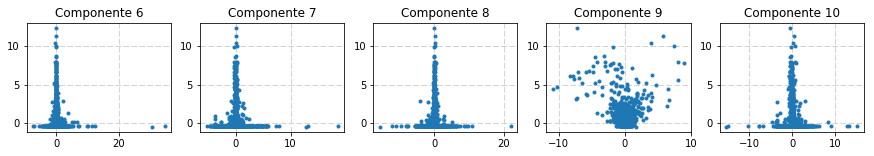

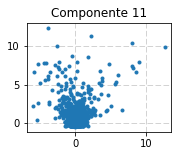

In [12]:
def plotResults():
    import matplotlib.pyplot as plt
    
    def plot(i, x, y, ncols, fig):
        if i % ncols == 0:
            fig = plt.figure(figsize=(15,2))
        ax = fig.add_subplot(1, ncols, 1+(i%ncols))
        ax.grid(color='lightgray', linestyle='--', linewidth=1)
        x_, y_ = [[*x] for x in zip(*sorted(zip(x,y)))]
        ax.plot(x_, y_, '.')
        ax.set_title("Componente {}".format(i+1))
        if i % ncols == ncols-1:
            plt.show()
        return fig

    transposed = np.transpose(x)
    
    fig = None
    ncols = 5
    print("Treino: Componentes do dado normalizado após o PCA")
    for i in range(len(transposed)):
        fig = plot(i, transposed[i], y, ncols, fig)
    plt.show()
    
    transposed = np.transpose(x_res)
    
    fig = None
    ncols = 5
    print("Resultado: Componentes do dado normalizado após o PCA")
    for i in range(len(transposed)):
        fig = plot(i, transposed[i], predFinal, ncols, fig)
    plt.show()
    
plotResults()

Visualmente os resultados parecem compatíveis com a base de teste.

    Obs.: O resultado esperado pelos dados de teste estão no arquivo ex6-result.csv  
          São criadas funções para trechos triviais para otimizar a memória disponível.
          O Gaussian foi deixado de lado devido ao incapacidade de suportar a memória exigida
          Os códigos para ensemble são grandemente inspirados por um post creditada 
          à Shahar Azulay & Ami Tavory. 
          Acessado em 17/06/2017. url: https://stackoverflow.com/a/35170149/3171285